In [1]:
import tensorflow as tf
from tensorflow.lite.experimental.microfrontend.python.ops import audio_microfrontend_op as frontend_op

import numpy as np
import time
# from pydub import AudioSegment
from scipy.io import wavfile
import random
import sys
import io
import os
import pathlib
import glob

# from td_utils import *
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
# To generate wav file from np array.
from scipy.io.wavfile import write

import IPython
import IPython.display as ipd

import pyaudio
from queue import Queue
from threading import Thread
import sys
import time

%matplotlib inline



In [17]:
model_file = 'keyword_model_50.h5'
i16min            = -32768
i16max            = 32767
fsamp             = 16000
wave_length_ms    = 1000
wave_length_samps = 16000
window_size_ms    = 60
window_step_ms    = 40
num_filters       = 32
use_microfrontend = True
label_list        = ['_silence', '_unknown', 'Active', 'stop']
spectrogram_shape = (64, 24, 32, 1)

Tx = spectrogram_shape[1] # The number of time steps input to the model from the spectrogram
num_filters = n_freq = spectrogram_shape[2] # Number of frequencies input to the model at each time step of the spectrogram


In [18]:
model = tf.keras.models.load_model(model_file)
print(f"Model input is: {model.input.shape}")
model.summary()

Model input is: (None, 24, 32, 1)
Model: "simple_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 22, 30, 20)        200       
                                                                 
 pool2 (MaxPooling2D)        (None, 11, 15, 20)        0         
                                                                 
 depthwise_conv2d (Depthwise  (None, 11, 15, 20)       200       
 Conv2D)                                                         
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 15, 32)        672       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 2, 3, 32)         0         
 )                                                               
                                                                 
 dropout (Dropout)    

In [19]:
def get_spectrogram(waveform):
  # Concatenate audio with padding so that all audio clips will be of the 
  # same length (16000 samples)
  zero_padding = tf.zeros([wave_length_samps] - tf.shape(waveform), dtype=tf.int16)
  waveform = tf.cast(0.5*waveform*(i16max-i16min), tf.int16)  # scale float [-1,+1]=>INT16
  equal_length = tf.concat([waveform, zero_padding], 0)
  ## Make sure these labels correspond to those used in micro_features_micro_features_generator.cpp
  spectrogram = frontend_op.audio_microfrontend(equal_length, sample_rate=fsamp, num_channels=num_filters,
                                    window_size=window_size_ms, window_step=window_step_ms)
  return spectrogram

1/1 [==============================] - 0s 78ms/step
3
Classification = stop
1/1 [==============================] - 0s 14ms/step
2
Classification = Active
1/1 [==============================] - 0s 11ms/step
0
Classification = _silence
1/1 [==============================] - 0s 12ms/step
2
Classification = Active
1/1 [==============================] - 0s 12ms/step
2
Classification = Active
1/1 [==============================] - 0s 11ms/step
3
Classification = stop
1/1 [==============================] - 0s 12ms/step
3
Classification = stop
1/1 [==============================] - 0s 11ms/step
2
Classification = Active
1/1 [==============================] - 0s 12ms/step
3
Classification = stop
1/1 [==============================] - 0s 13ms/step
2
Classification = Active


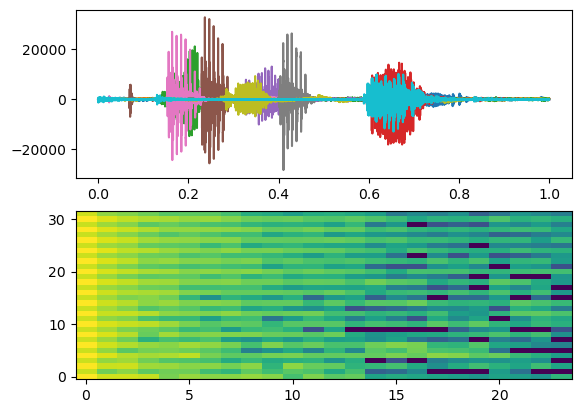

In [5]:
wav_dir = pathlib.Path(os.path.join('data/mini_speech_commands/up/'))
wav_list = os.listdir(wav_dir)
wav_file = [os.path.join(wav_dir, wav_list[x]) for x in range(len(wav_list))]

label_list = ['_silence', '_unknown', 'Active', 'stop']

for i in range(10):
    
    fs, test_wav = wavfile.read(wav_file[i])
#     print(f"Fsamp = {fs}.  wav shape = {test_wav.shape}")
    test_spec = get_spectrogram(test_wav)
#     print(f"spec shape = {test_spec.shape}")
    plt.subplot(2,1,1)
    plt.plot(np.arange(len(test_wav))/fs, test_wav)
    plt.subplot(2,1,2)
    plt.imshow(test_spec.numpy().T, aspect='auto', origin='lower', interpolation='none')
    ipd.Audio(test_wav, rate=fs)
    y = model.predict(np.expand_dims(test_spec, [0,-1]))
#     print(y)
    print(np.argmax(y))
#     if label_list[np.argmax(y)] =='Active':
    print(f"Classification = {label_list[np.argmax(y)]}")

In [6]:
def detect_triggerword_spectrum(x):
    # the spectogram outputs  and we want (Tx, freqs) to input into the model
    x  = x.swapaxes(0,1)
    x = np.expand_dims(x, axis=0)
    predictions = model.predict(x)
    return predictions.reshape(-1)

def has_new_triggerword(predictions, chunk_duration, feed_duration, threshold=0.5):
    predictions = predictions > threshold
    chunk_predictions_samples = int(len(predictions) * chunk_duration / feed_duration)
    chunk_predictions = predictions[-chunk_predictions_samples:]
    level = chunk_predictions[0]
    for pred in chunk_predictions:
        if pred > level:
            return True
        else:
            level = pred
    return False

In [7]:
chunk_duration = 0.25 # Each read length in seconds from mic.
fs = 16000 # sampling rate for mic
chunk_samples = int(fs * chunk_duration) # Each read length in number of samples.

# Each model input data duration in seconds, need to be an integer numbers of chunk_duration
feed_duration = 1.0
feed_samples = int(fs * feed_duration)

assert feed_duration/chunk_duration == int(feed_duration/chunk_duration)

In [8]:
# Queue to communiate between the audio callback and main thread
q = Queue()

run = True

silence_threshold = 500

# Run the demo for a timeout seconds
timeout = time.time() + 1 

# Data buffer for the input wavform
data = np.zeros(feed_samples, dtype='int16')

def callback(in_data, frame_count, time_info, status):
    global run, timeout, data, silence_threshold    
    if time.time() > timeout:
        run = False        
    data0 = np.frombuffer(in_data, dtype='int16')
    data = np.append(data,data0)    
    if len(data) > feed_samples:
        data = data[-feed_samples:]
        # Process data async by sending a queue.
        q.put(data)
    return (in_data, pyaudio.paContinue)


stream = pyaudio.PyAudio().open(
    format=pyaudio.paInt16,
    channels=1,
    rate=fs,
    input=True,
    frames_per_buffer=chunk_samples,
    input_device_index=0,
    stream_callback=callback)
stream.start_stream()

try:
    while run:
        data = q.get()

except (KeyboardInterrupt, SystemExit):
    stream.stop_stream()
    stream.close()
    timeout = time.time()
    run = False
        
stream.stop_stream()
stream.close()

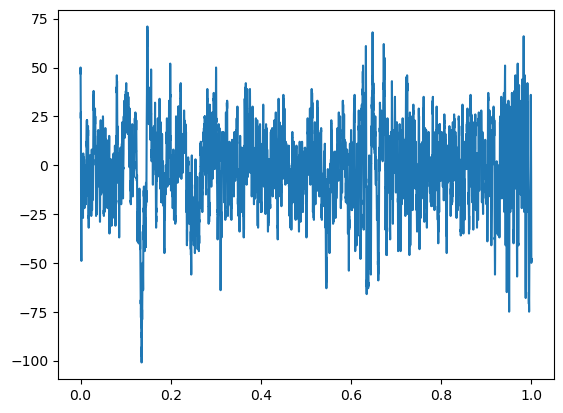

In [9]:
plt.plot(np.arange(1*fs)/fs, data)


In [10]:
n=1
print(data.shape)
 # [n:n+int(fs)]
right_wav = data.copy()
ipd.Audio(data, rate=fs)

(16000,)


(24, 32)


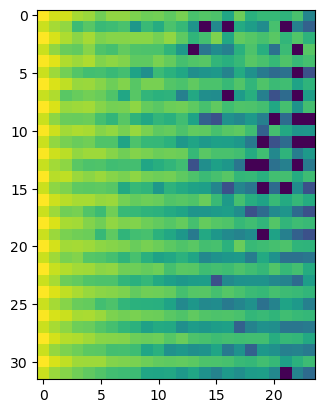

In [11]:
right_spec = get_spectrogram(right_wav)
print(right_spec.shape)
plt.imshow(right_spec.numpy().T)

In [12]:
print(model.input.shape)
print(right_spec.shape)
xx = np.expand_dims(right_spec, [0,-1])
yy = model.predict(xx)
pred_str = label_list[np.argmax(yy)]
print(f"Classified as \'{pred_str}\'")

(None, 24, 32, 1)
(24, 32)
1/1 [==============================] - 0s 11ms/step
Classified as 'Active'


In [13]:
unknown_count=0
Active_count=0
silence_count=0
stop_count=0
# Queue to communiate between the audio callback and main thread
q = Queue()

run = True

silence_threshold = 500

# Run the demo for a timeout seconds
timeout = time.time() + 30

# Data buffer for the input wavform
data = np.zeros(feed_samples, dtype='int16')

def callback(in_data, frame_count, time_info, status):
    global run, timeout, data, silence_threshold 

    if time.time() > timeout:
        run = False        
    data0 = np.frombuffer(in_data, dtype='int16')
    if np.abs(data0).mean() < silence_threshold:
        sys.stdout.write('_')
        # return (in_data, pyaudio.paContinue)
    else:
        sys.stdout.write('*')
    data = np.append(data,data0)    
    if len(data) > feed_samples:
        data = data[-feed_samples:]
        # Process data async by sending a queue.
        q.put(data)
    return (in_data, pyaudio.paContinue)


stream = pyaudio.PyAudio().open(
    format=pyaudio.paInt16,
    channels=1,
    rate=fs,
    input=True,
    frames_per_buffer=chunk_samples,
    input_device_index=0,
    stream_callback=callback)
stream.start_stream()

try:
    while run:
        new_samples = q.get()
        mean_abs = np.abs(new_samples).mean()
        #print(f"Mean abs val = {mean_abs}")
        if mean_abs >= silence_threshold:
            spectrum = get_spectrogram(new_samples)
            spectrum = np.expand_dims(spectrum, [0,-1])
            yy = model.predict(spectrum)
            pred_str = label_list[np.argmax(yy)]
            print(f"Detected {pred_str}")
            if pred_str=='stop':
                stop_count=stop_count+1
            if pred_str=="_unknown":
                unknown_count=unknown_count+1
            if pred_str=="Active":
                Active_count=Active_count+1
            if pred_str=="_silence":
                silence_count=silence_count+1
        
except (KeyboardInterrupt, SystemExit):
    stream.stop_stream()
    stream.close()
    timeout = time.time()
    run = False
        
stream.stop_stream()
stream.close()

1/1 [==============================] - 0s 14ms/step
Detected Active
1/1 [==============================] - 0s 16ms/step
Detected stop
1/1 [==============================] - 0s 14ms/step
Detected Active
1/1 [==============================] - 0s 15ms/step
Detected Active
1/1 [==============================] - 0s 14ms/step
Detected _silence
1/1 [==============================] - 0s 15ms/step
Detected _silence
1/1 [==============================] - 0s 21ms/step
Detected stop
1/1 [==============================] - 0s 15ms/step
Detected _silence
1/1 [==============================] - 0s 17ms/step
Detected Active
1/1 [==============================] - 0s 15ms/step
Detected stop
1/1 [==============================] - 0s 16ms/step
Detected stop
1/1 [==============================] - 0s 14ms/step
Detected stop
1/1 [==============================] - 0s 14ms/step
Detected _silence
1/1 [==============================] - 0s 14ms/step
Detected Active
1/1 [==============================] - 0s 16ms/ste

In [14]:
print("stop count:", stop_count)
print("Active count:", Active_count)
print("Silence count:",silence_count)
print("Unknown count:",unknown_count)

stop count: 20
Active count: 27
Silence count: 9
Unknown count: 0


In [15]:
unknown_count=0
Active_count=0
silence_count=0
stop_count=0
# Queue to communiate between the audio callback and main thread
q = Queue()

run = True

silence_threshold = 100

# Run the demo for a timeout seconds
timeout = time.time() + 30

# Data buffer for the input wavform
data = np.zeros(feed_samples, dtype='int16')

def callback(in_data, frame_count, time_info, status):
    global run, timeout, data, silence_threshold 

    if time.time() > timeout:
        run = False        
    data0 = np.frombuffer(in_data, dtype='int16')
    if np.abs(data0).mean() < silence_threshold:
        sys.stdout.write('_')
        # return (in_data, pyaudio.paContinue)
    else:
        sys.stdout.write('*')
    data = np.append(data,data0)    
    if len(data) > feed_samples:
        data = data[-feed_samples:]
        # Process data async by sending a queue.
        q.put(data)
    return (in_data, pyaudio.paContinue)


stream = pyaudio.PyAudio().open(
    format=pyaudio.paInt16,
    channels=1,
    rate=fs,
    input=True,
    frames_per_buffer=chunk_samples,
    input_device_index=0,
    stream_callback=callback)
stream.start_stream()

try:
    while run:
        new_samples = q.get()
        mean_abs = np.abs(new_samples).mean()
        #print(f"Mean abs val = {mean_abs}")
        if mean_abs >= silence_threshold:
            spectrum = get_spectrogram(new_samples)
            spectrum = np.expand_dims(spectrum, [0,-1])
            yy = model.predict(spectrum)
            pred_str = label_list[np.argmax(yy)]
            print(f"Detected {pred_str}")
            if pred_str=='stop':
                stop_count=stop_count+1
            if pred_str=="_unknown":
                unknown_count=unknown_count+1
            if pred_str=="Active":
                Active_count=Active_count+1
            if pred_str=="_silence":
                silence_count=silence_count+1
        
except (KeyboardInterrupt, SystemExit):
    stream.stop_stream()
    stream.close()
    timeout = time.time()
    run = False
        
stream.stop_stream()
stream.close()

1/1 [==============================] - 0s 15ms/step
Detected Active
1/1 [==============================] - 0s 15ms/step
Detected stop
1/1 [==============================] - 0s 16ms/step
Detected Active
1/1 [==============================] - 0s 16ms/step
Detected stop
1/1 [==============================] - 0s 15ms/step
Detected Active
1/1 [==============================] - 0s 15ms/step
Detected Active
1/1 [==============================] - 0s 15ms/step
Detected _silence
1/1 [==============================] - 0s 15ms/step
Detected Active
1/1 [==============================] - 0s 18ms/step
Detected stop
1/1 [==============================] - 0s 11ms/step
Detected Active
1/1 [==============================] - 0s 14ms/step
Detected Active
1/1 [==============================] - 0s 15ms/step
Detected Active
1/1 [==============================] - 0s 14ms/step
Detected _silence
1/1 [==============================] - 0s 16ms/step
Detected _silence
1/1 [==============================] - 0s 14ms/s

In [16]:
print("stop count:", stop_count)
print("Active count:", Active_count)
print("Silence count:",silence_count)
print("Unknown count:",unknown_count)

stop count: 24
Active count: 61
Silence count: 9
Unknown count: 0
